# <Center>**Utilizing Text Analysis in Predicting Party Affiliations and Identifying Speech Similarities in the 105th Senate**
    
### <Center>Ian Brandenburg <center>[Medium Article](https://medium.com/@iandrewburg/utilizing-text-analysis-in-predicting-party-affiliations-and-identifying-speech-similarities-in-the-dd488c16cf18) <center> [GitHub Repo](https://github.com/Iandrewburg/Text_Analysis/tree/main/Assignments)

    
This text analysis assignment takes a look into senators' speeches compared to Biden's speeches. The objective is to determine which senators have the most similar speeches to Biden using cosine similarity. The speeches for each senator were use in aggregation of the senator instead of splitting up the speeches. Thus, the entire senator file was create as one document. The text will be processed utilizing three different text processing techniques. The first method is a basic text processing method, which tokenizes all of the text after lowercasing, removing numbers, punctuation, and SK Learn stopwords. The second text processing method utilizes stemming while the third utilizes lemmatization. Both of these methods are used on the already preprocessed text. 
    
Once the text processing was complete, visualizations were developed in order to visualize the most similar senators' speeches to Biden's speeches. Additionally, these similarities were integrated with the sen105kh_fix.csv to see if the most similar speeches belong to senators from the same party and/or state. These validations were also visualized. 
    
Finally, three predictive model measures were utilized to analyze the predictive power the speeches have in determining the party of the senator. These three models include: Linear Regression, Multinomial Naive Bayes, and Gaussian Naive Bayes. Each of them were run to compare their results. 

---


In [81]:
import os
import time
import re
import string
import pandas as pd
import numpy as np
import requests
import matplotlib as plt
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.svm import SVC

import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet

# Initializing the tfidf vectorizers
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer_stem = TfidfVectorizer()
tfidf_vectorizer_lem = TfidfVectorizer()

# Initializing the CountVectorizer (BoW model)
count_vectorizer = CountVectorizer()

# Initializing the Multinomial Naive Bayes classifier
model_mnb = MultinomialNB()

# Initialize the Gaussian Naive Bayes model
model_gnb = GaussianNB()

import warnings
warnings.filterwarnings('ignore')


In [101]:
def read_speech(file_path):
    with open(file_path, 'r') as file:
        return file.read()

def preprocess_text(text):
    """
    Input: text
    Output: Tokenized text that has been scrubbed. The text is
    lower cased, and punctuation, numbers, and stopwords are removed.
    """
    text = text.lower()
    tokens = [word for word in text.split() if word.isalpha() and word not in ENGLISH_STOP_WORDS]
    return ' '.join(tokens)


def stem_text(text):
    """
    Input: text (str): Preprocessed text to stem.
    Output: str: The stemmed text.
    """
    stemmer = PorterStemmer()
    tokens = text.split()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)


def lemmatize_text(text):
    """
    Input: text (str): Preprocessed text to lemmatize.
    Output: str: The lemmatized text.
    """
    lemmatizer = WordNetLemmatizer()
    tokens = text.split()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)


def plot_cosine_similarity_by_party(df, cosine_similarity_column):
    """
    Plots the top 5 senators based on the specified cosine similarity column,
    colored by party.

    Parameters:
    - df: DataFrame containing the senators' speeches and similarity scores.
    - cosine_similarity_column: The name of the column with cosine similarity scores.
    - plot_title: Optional. The title of the plot.
    """
    top_senators = df.sort_values(by=cosine_similarity_column, ascending=False).iloc[1:6]
    colors = ['blue' if party == 'Democrat' else 'red' for party in top_senators['party']]
    # Creating the plot
    plt.figure(figsize=(8, 4))
    plt.bar(top_senators['name'], top_senators[cosine_similarity_column], color=colors)
    
    # Setting labels and title
    plt.xlabel('')
    plt.ylabel('')
    plt.ylim(top_senators[cosine_similarity_column].min() - 0.01, top_senators[cosine_similarity_column].max() + 0.01)
    plt.title(f'Top 5 Senators - {cosine_similarity_column}')
    plt.xticks(rotation=45)
    plt.legend(['Democrat', 'Republican'], loc='upper right')
    plt.tight_layout()
    plt.savefig(f"Figures/top_5_senators_{cosine_similarity_column}.png")
    plt.show()
    

def plot_top_words(senator_name, speech_column):
    """
    Plot the top 10 most frequent words for a given senator's speech.

    Parameters:
    - df: DataFrame containing the senators' speeches.
    - senator_name: The name of the senator to plot the words for.
    - speech_column: The column name containing the preprocessed speech text.
    """
    # finding the row for the senator
    senator_row = senators_speeches[senators_speeches['name'] == senator_name].iloc[0]
    
    # tokenizing the speech
    words = senator_row[speech_column].split()
    
    # using the counter to count the frequency of each word
    word_counts = Counter(words)
    
    # getting the top 10 most common words and their counts
    top_words = word_counts.most_common(10)
    
    # unzipping the words and their counts
    words, counts = zip(*top_words)
    
    # plot
    plt.figure(figsize=(10, 6))
    plt.bar(words, counts, color='#3b9e9e')
    plt.xlabel('')
    plt.ylabel('')
    plt.title(f'Top 10 Most Frequent Words in {senator_name}\'s Speeches')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"Figures/most_frequent_words_{senator_name}.png")
    plt.show()

def logistic_regression(X, y):
    """
    Train a logistic regression model to predict the senator's party based on their precomputed TF-IDF matrix.
    Uses class weights to handle class imbalance.

    Parameters:
    - X: The precomputed TF-IDF matrix of the speeches.
    - y: The labels (party affiliations).
    """
    # computing class weights to handle imbalance
    classes = np.unique(y)
    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
    class_weights_dict = dict(zip(classes, class_weights))
    
    # splitting the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=20240324)

    # initializing logistic regression with computed class weights
    model_lr = LogisticRegression(class_weight=class_weights_dict, max_iter=1000)

    # training the classifier
    model_lr.fit(X_train, y_train)

    # predicting on the test data
    y_predicted = model_lr.predict(X_test)

    # calculating the accuracy
    accuracy = accuracy_score(y_test, y_predicted)
    print(classification_report(y_test, y_predicted, zero_division=0))

    return accuracy


def multinomial_nb(tfidf_matrix, y):
    
    # converting the party labels to numpy array
    y = np.array(y)
    
    # splitting the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, y, test_size=0.5, random_state = 20240324)
    
    # training the model
    model_mnb.fit(X_train, y_train)
    
    # predicting on the test data
    y_pred = model_mnb.predict(X_test)
    
    # calculating the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(classification_report(y_test, y_pred, zero_division=0))
    
    return accuracy


def gaussian_nb(tfidf_matrix, y):
    
    # converting the party labels to numpy array
    y = np.array(y)
    
    # Since GaussianNB does not support sparse input, converting the sparse TF-IDF matrix to dense
    X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix.toarray(), y, test_size=0.5, random_state=20240324)
    
    # training the model
    model_gnb.fit(X_train, y_train)
    
    # predicting on the test data
    y_pred = model_gnb.predict(X_test)
    
    # calculating the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(classification_report(y_test, y_pred, zero_division=0))
    
    return accuracy

In [3]:
# path to the directory containing the speeches
speeches_dir = 'C:/Users/iandr/masters_coding/Second Semester/Python_Programming_Viz_Text/Course_Materials/Inputs/105-extracted-date'

# Initialize an empty list to store each senator's speech data
senator_speeches = []

### 1) Using cosine similarity to determine which senator's speech is closest to Senator Biden's. 

The text preprocessing measures were set in a function above in the function code chunk. The text is lower cased, with stopwords, numbers, symbols and punctuation being removed. This is because there is no need for these characters or words to be included in the analysis, as they just create extra unnecessary noise. The findings are validated with the `sen105kh_fix.csv` to see if the most similar speeches belong to the senators from the same state and/or party. None of the most similar speeches belonged to the same state, but the most similar speech belong to John Kerry, who belongs to the same party. 


#### Read speeches into the senator_speeches library

Here, the senator speeches are read through the read speech function, and fed into the senator_speeches library, using the name of the documents (which includes the senators' name) as the key.

In [4]:
for file_name in os.listdir(speeches_dir):
    if file_name.endswith('.txt'):
        
        # extracting the state abbreviation, which is between the last dash and '.txt'
        state_abbr = file_name[-6:-4]  # The state abbreviation is the two letters before '.txt'
        
        # Manually removing the first 4 characters ('105-') and the last 7 characters ('-xx.txt')
        # to get the senator's name
        senator_name = file_name[4:-7]
        
        file_path = os.path.join(speeches_dir, file_name)
        
        # using the read_speech function to get the speech content
        speech_content = read_speech(file_path)
        
        # appending the senator's name, speech content, and state abbreviation as a tuple to the list
        senator_speeches.append((senator_name, speech_content, state_abbr))


In [5]:
# creating a DataFrame from the list
speeches_df = pd.DataFrame(senator_speeches, columns=['name', 'speech', 'state_abbr'])

# checking the dataframe to see the results 
speeches_df

,name,speech,state_abbr
0,abraham,<DOC>\n<DOCNO>105-abraham-mi-1-19981112</DOCNO...,mi
1,akaka,<DOC>\n<DOCNO>105-akaka-hi-1-19981021</DOCNO>\...,hi
2,allard,<DOC>\n<DOCNO>105-allard-co-1-19981009</DOCNO>...,co
3,ashcroft,<DOC>\n<DOCNO>105-ashcroft-mo-1-19981021</DOCN...,mo
4,baucus,<DOC>\n<DOCNO>105-baucus-mt-1-19981021</DOCNO>...,mt
...,...,...,...
95,thurmond,<DOC>\n<DOCNO>105-thurmond-sc-1-19981021</DOCN...,sc
96,torricelli,<DOC>\n<DOCNO>105-torricelli-nj-1-19981012</DO...,nj
97,warner,<DOC>\n<DOCNO>105-warner-va-1-19981021</DOCNO>...,va
98,wellstone,<DOC>\n<DOCNO>105-wellstone-mn-1-19981021</DOC...,mn


#### Preprocess the speeches

Using the preprocess function, preprocess all speeches in the library

In [6]:
# preprocessing all speeches
speeches_df['processed_speech'] = speeches_df['speech'].apply(preprocess_text)

# dropping the 'speech' column from the DataFrame
speeches_df = speeches_df.drop(columns=['speech'])

# displaying the DataFrame to verify the column has been removed
speeches_df

,name,state_abbr,processed_speech
0,abraham,mi,debate final passage omnibus appropriations am...
1,akaka,hi,pleased senate passed veterans programs enhanc...
2,allard,co,rise make remarks concerning auto choice refor...
3,ashcroft,mo,senate like hear order happy yield colleague r...
4,baucus,mt,understand house sent senate substitute coast ...
...,...,...,...
95,thurmond,sc,senate considers authorize president award med...
96,torricelli,nj,president thank senator senator majority leade...
97,warner,va,past senate armed services committee conducted...
98,wellstone,mn,like attention small important issue addressed...


#### Convert to TFIDF vectors and set biden's speech

Convert the processed speeches to a tfidf matrix using the tfidf vectorizer, initialized along with the import libraries portion of the code. 

Additionally, this chunk of code sets biden's speeches as biden_index so that there is a speech to compare the others to in the cosine similarity. 

In [7]:
# convert to TF-IDF vectors
tfidf_matrix_norm = tfidf_vectorizer.fit_transform(speeches_df['processed_speech'])

# setting biden's row
biden_row = speeches_df[speeches_df['name'].str.contains('biden')].index[0]

#### Applying the Cosine Similarity Function and printing the top 5 senators and their similarity scores to biden's speeches. 


In [8]:
# computing cosine similarity matrix for TF-IDF vectors
cosine_sim_matrix = cosine_similarity(tfidf_matrix_norm)

# extracting the cosine similarity scores relative to Biden's speech
biden_similarity_scores = cosine_sim_matrix[biden_row]

# adding the scores to speeches_df
speeches_df['preprocessed_co_sim'] = biden_similarity_scores

# sorting the DataFrame by the new 'preprocessed_co_sim' column to get top similarity scores
top_similar_speeches_df = speeches_df.sort_values(by='preprocessed_co_sim', ascending=False)
top_similar_speeches_df.iloc[1:6]


,name,state_abbr,processed_speech,preprocessed_co_sim
59,kerry,ma,ask distinguished colleague chairman committee...,0.792525
61,kyl,az,parts concern proud provision known workplace ...,0.784532
51,hutchison,tx,happy yield senator want add wonderful words s...,0.782242
66,lieberman,ct,want add voice supporting passage vacancies re...,0.781326
81,roberts,ks,thank thank presiding officer yield domenici a...,0.776708


#### Reading in the senator information CSV

Here, the senator information CSV is read in, being separated by ';'. This is for comparing senator information to biden's to see if there are any visable similarites or consistentcies in the party or state of the top five most similar speeches to Biden's. 

In [9]:
# path to the CSV file
csv_path = "C:/Users/iandr/masters_coding/Second Semester/Python_Programming_Viz_Text/Course_Materials/Inputs/sen105kh_fix.csv"

# loading the CSV for validation, using ';' as the separator 
senators_info = pd.read_csv(csv_path, sep=';')

# establishing the csv column names, and the top five senators' name
senators_info.columns = ['cong', 'name', 'state_abbr', 'state', 'id', 'dist', 'party']

# Changing the 200 and 100 to their respective parties for easier analysis
senators_info['party'] = senators_info['party'].replace({200: 'Republican', 100: 'Democrat'})
senators_info.head()


,cong,name,state_abbr,state,id,dist,party
0,105,sessions,al,ALABAMA,49700,0,Republican
1,105,shelby,al,ALABAMA,94659,0,Republican
2,105,murkowski,ak,ALASKA,14907,0,Republican
3,105,stevens,ak,ALASKA,12109,0,Republican
4,105,kyl,az,ARIZONA,15429,0,Republican


#### Merging the two Dataframes

This code merges the speech data and the senators info csv into one dataframe for a more streamlined analysis. The dataframes are merged on both name and state abbreviation because, after further investigation, there were two senators with the same name, causing merging issues. 

In [10]:
# merge speeches_df and senator_info DataFrames on the 'name' column
senators_speeches = pd.merge(speeches_df, senators_info, on=['name', 'state_abbr'], how='left')
senators_speeches.head()

,name,state_abbr,processed_speech,preprocessed_co_sim,cong,state,id,dist,party
0,abraham,mi,debate final passage omnibus appropriations am...,0.713053,105,MICHIGA,49500,0,Republican
1,akaka,hi,pleased senate passed veterans programs enhanc...,0.458571,105,HAWAII,14400,0,Democrat
2,allard,co,rise make remarks concerning auto choice refor...,0.656932,105,COLORAD,29108,0,Republican
3,ashcroft,mo,senate like hear order happy yield colleague r...,0.733304,105,MISSOUR,49501,0,Republican
4,baucus,mt,understand house sent senate substitute coast ...,0.714337,105,MONTANA,14203,0,Democrat


In [11]:
# displaying the top five seantor speeches in comparison to bidens
top_five_validated = senators_speeches.sort_values(by='preprocessed_co_sim', ascending=False)
top_five_validated.iloc[0:6][['party', 'state_abbr', 'preprocessed_co_sim', 'name']]

,party,state_abbr,preprocessed_co_sim,name
6,Democrat,de,1.000000,biden
59,Democrat,ma,0.792525,kerry
61,Republican,az,0.784532,kyl
51,Republican,tx,0.782242,hutchison
66,Democrat,ct,0.781326,lieberman
81,Republican,ks,0.776708,roberts


#### Party and State similarities

The top five senators do not seem to have very many consistencies with Biden's speeches. Since there are only two parties, it could be considered a coincidence that there are similar parties to Biden's in the top five senators listed here. Only two senators have the same party, and no senator has the same state as Biden. 

### 2) How do your results change if you apply stemming or lemmatization? In your opinion, which is better to apply: stemming or lemmatization? Why?
---

The results do change. Stemming and lemmatization increases the similarity scores as compared to the standard preprocessing. This is because these techniques remove extra noise in the data. Stemming seemed to be the best option, as it increased the cosine similarity the most. This is likely because it reduces words to its simple root word, whereas lemmatization narrows the text down to its root lemma based on the lexicon and also attempts to consider the meaning of the word. Stemming perhaps finds more similarities as a result of its simpler approach, but it should be noted that these can be a limitation because it can mislabel words since it does not consider the meaning of the words. 

In [12]:
# Applying stemming
start_time = time.time()
senators_speeches['stemmed_speech'] = senators_speeches['processed_speech'].apply(stem_text)
print(f"Stemming completed. Time taken: {time.time() - start_time:.2f}s")


Stemming completed. Time taken: 171.18s


In [13]:
# Applying lemmatizing
start_time = time.time()
senators_speeches['lemmatized_speech'] = senators_speeches['processed_speech'].apply(lemmatize_text)
print(f"Lemmatization completed. Time taken: {time.time() - start_time:.2f}s")


Lemmatization completed. Time taken: 5479.57s


In [14]:
# Applying Bag of Words
start_time = time.time()
bow_matrix = count_vectorizer.fit_transform(senators_speeches['processed_speech'])
print(f"BoW vectorization completed. Time taken: {time.time() - start_time:.2f}s")

BoW vectorization completed. Time taken: 6.09s


In [15]:
# Vectorizing the speeches
start_time = time.time()
tfidf_matrix_stem = tfidf_vectorizer_stem.fit_transform(senators_speeches['stemmed_speech'])
tfidf_matrix_lemmatize = tfidf_vectorizer_lem.fit_transform(senators_speeches['lemmatized_speech'])
print(f"TF-IDF vectorization completed. Time taken: {time.time() - start_time:.2f}s")


TF-IDF vectorization completed. Time taken: 10.67s


In [16]:
# Calculating Cosine Similarity for both Stemmed and Lemmatized Speeches with biden's speeches
cosine_sim_stem = cosine_similarity(tfidf_matrix_stem, tfidf_matrix_stem[biden_row:biden_row+1])
cosine_sim_lem = cosine_similarity(tfidf_matrix_lemmatize, tfidf_matrix_lemmatize[biden_row:biden_row+1])
cosine_sim_bow = cosine_similarity(bow_matrix, bow_matrix[biden_row:biden_row+1])

In [17]:
senators_speeches['stemming_co_sim'] = cosine_sim_stem.flatten()
senators_speeches['lemmatization_co_sim'] = cosine_sim_lem.flatten()
senators_speeches['bow_co_sim'] = cosine_sim_bow.flatten()

In [18]:
# displaying the top five most similar speeches to bidens when using stemming
senators_speeches.sort_values(by='stemming_co_sim', ascending=False).iloc[0:6][['name', 'state_abbr', 'party', 'stemming_co_sim']]


,name,state_abbr,party,stemming_co_sim
6,biden,de,Democrat,1.000000
59,kerry,ma,Democrat,0.842858
61,kyl,az,Republican,0.834385
66,lieberman,ct,Democrat,0.831528
81,roberts,ks,Republican,0.828646
15,byrd,wv,Democrat,0.825766


In [19]:
# displaying the top five most similar speeches to bidens when using lemmatization
senators_speeches.sort_values(by='lemmatization_co_sim', ascending=False).iloc[0:6][['name', 'state_abbr', 'party', 'lemmatization_co_sim']]


,name,state_abbr,party,lemmatization_co_sim
6,biden,de,Democrat,1.000000
59,kerry,ma,Democrat,0.807746
61,kyl,az,Republican,0.801307
66,lieberman,ct,Democrat,0.799500
51,hutchison,tx,Republican,0.799329
81,roberts,ks,Republican,0.793694


In [20]:
# displaying the top five most similar speeches to bidens when using bag of words
senators_speeches.sort_values(by='bow_co_sim', ascending=False).iloc[0:6][['name', 'state_abbr', 'party', 'bow_co_sim']]


,name,state_abbr,party,bow_co_sim
6,biden,de,Democrat,1.000000
59,kerry,ma,Democrat,0.828760
35,feinstein,ca,Democrat,0.826931
66,lieberman,ct,Democrat,0.825679
51,hutchison,tx,Republican,0.821979
81,roberts,ks,Republican,0.820142


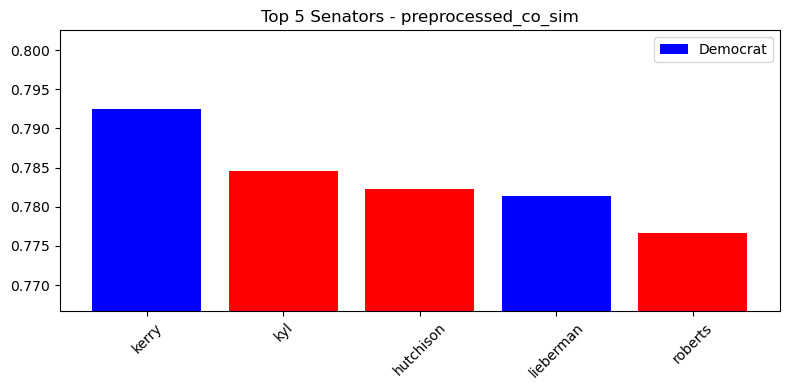

In [49]:
plot_cosine_similarity_by_party(senators_speeches, 'preprocessed_co_sim')

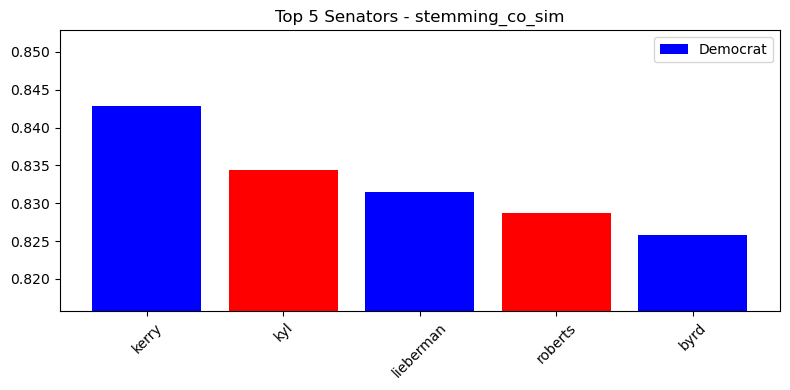

In [50]:
plot_cosine_similarity_by_party(senators_speeches, 'stemming_co_sim')

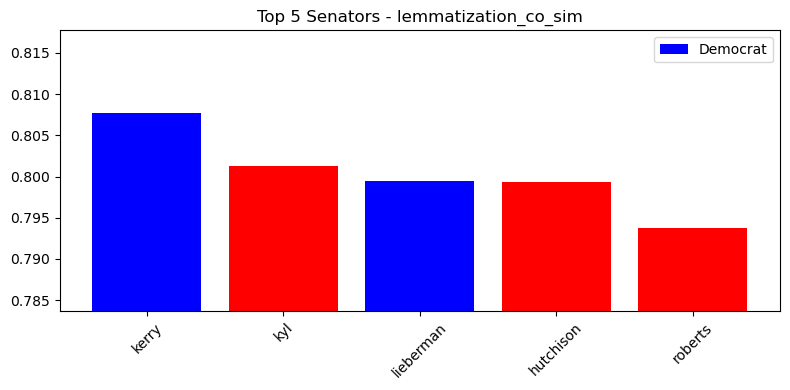

In [51]:
plot_cosine_similarity_by_party(senators_speeches, 'lemmatization_co_sim')

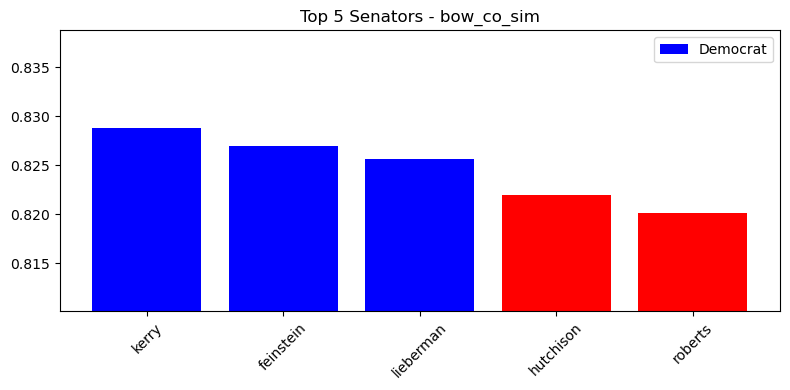

In [52]:
plot_cosine_similarity_by_party(senators_speeches, 'bow_co_sim')

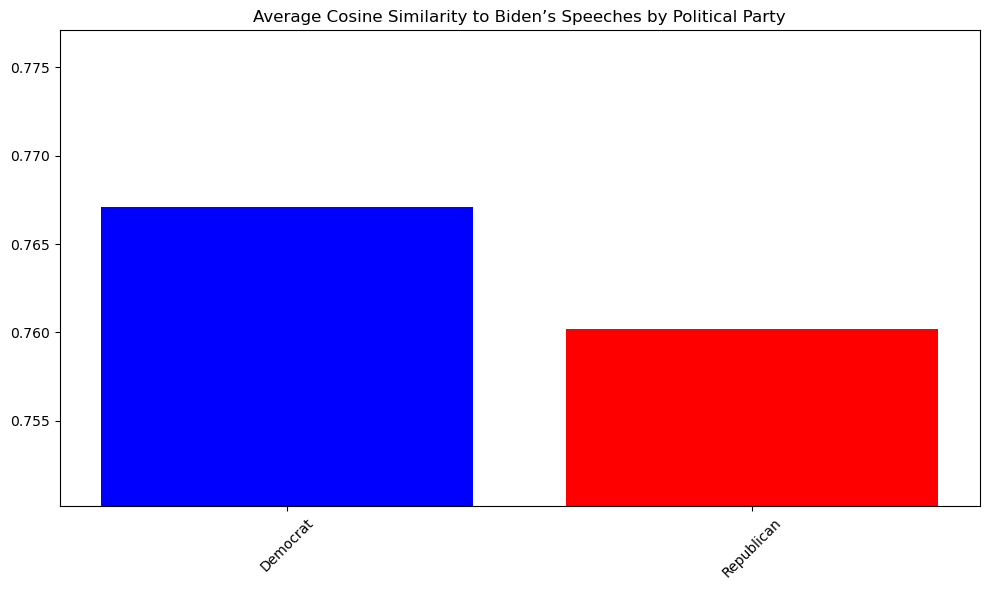

In [25]:
# calculating the average cosine similarity by party
avg_similarity_by_party = senators_speeches.groupby('party')['stemming_co_sim'].mean().reset_index()

# plotting bar chart
plt.figure(figsize=(10, 6))
plt.bar(avg_similarity_by_party['party'], avg_similarity_by_party['stemming_co_sim'], color=['blue', 'red'])
plt.xlabel('')
plt.ylabel('')
plt.title('Average Cosine Similarity to Biden’s Speeches by Political Party')
plt.xticks(rotation=45)

# narrowing the y-axis for a better visual representation
plt.ylim(avg_similarity_by_party['stemming_co_sim'].min() - 0.01, avg_similarity_by_party['stemming_co_sim'].max() + 0.01)  # Set the limits for y-axis to make differences more pronounced

plt.tight_layout()
plt.savefig("Figures/avg_sim_by_party.png")
plt.show()

The Democrat Party can be seen to have a slightly larger cosine similarity average as compared to the Republican Party. This suggests that the political affiliation does have some influence on similarity, but is not necessarily causal. With these mutually similar bi-partisan similarity scores, these text analysis techniques may not be the most efficient in determining the political affiliation of a politician, and political party may not explain why a senator's speeches are so similar to Biden's. There are large differences in the opinions held by each political party, so narrowing down the text to target even more meaningful text may be necessary for future research.

### 3) Create at least two visualizations to support your analysis.

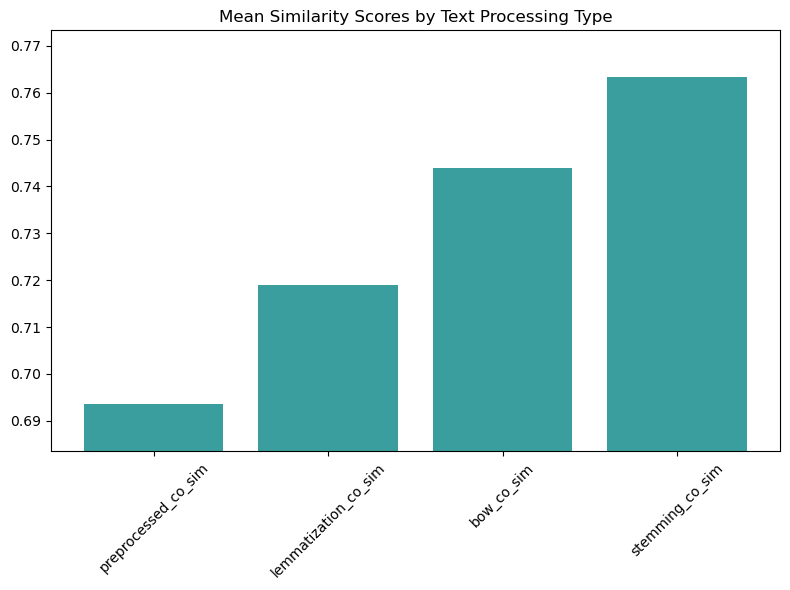

In [26]:
# calculating the average cosine similarity scores for each processing type
mean_scores = pd.DataFrame({
    'Type': ['stemming_co_sim', 'bow_co_sim', 'lemmatization_co_sim', 'preprocessed_co_sim'],
    'Score': [
        senators_speeches['stemming_co_sim'].mean(),
        senators_speeches['bow_co_sim'].mean(),
        senators_speeches['lemmatization_co_sim'].mean(),
        senators_speeches['preprocessed_co_sim'].mean()
    ]
})

# sorting the scores for plotting
mean_scores = mean_scores.sort_values(by='Score')

# plotting
plt.figure(figsize=(8, 6))
plt.bar(mean_scores['Type'], mean_scores['Score'], color='#3b9e9e')
plt.title('Mean Similarity Scores by Text Processing Type')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=45)

# narrowing the y-axis to better visualize differences
plt.ylim(mean_scores['Score'].min() - 0.01, mean_scores['Score'].max() + 0.01)

plt.tight_layout()
plt.savefig("Figures/mean_similarity_by_processing_type.png")
plt.show()

Stemming seems to yield the most similar results. This could be viewed as a limitation, since sometimes the stemming algorithm can mistakenly generate incorrect root words to unrelated words, creating a higher similarity rate. Nevertheless, based on these results, the stemming method may be the most optimal method to proceed forward with. Thus, the top five most similar senator speeches to Biden are by Kerry (D), Kyl (R), Lieberman (D), Roberts (R), and Byrd (D).

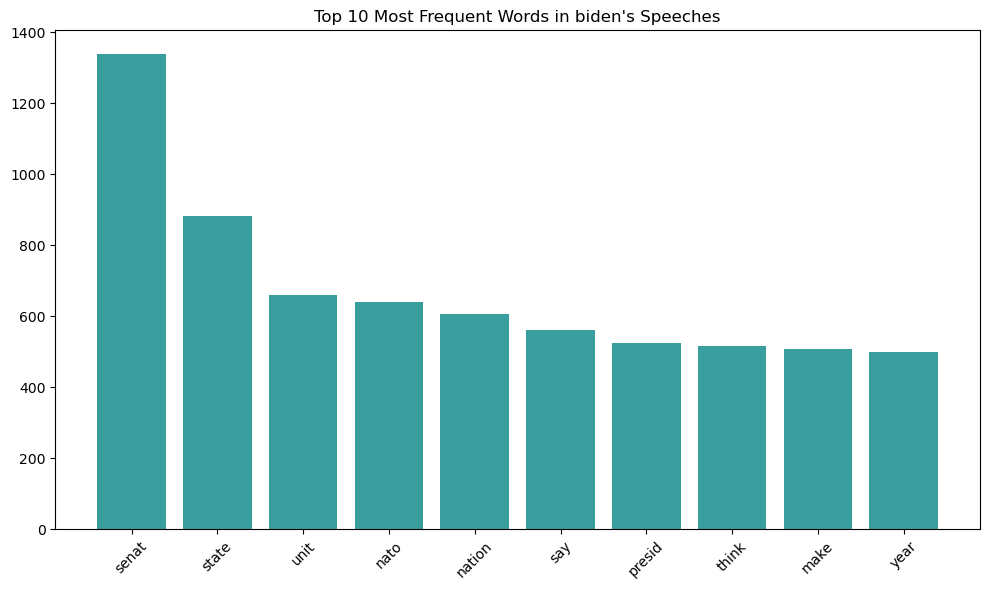

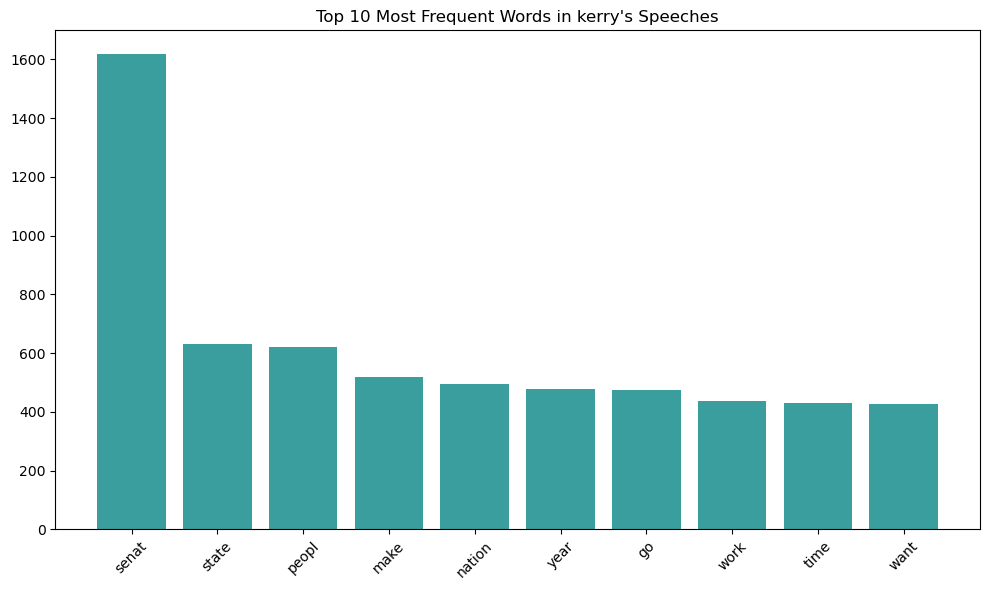

In [27]:
# plotting the top words
plot_top_words("biden", "stemmed_speech")
plot_top_words("kerry", "stemmed_speech")


The top words from Biden and Kerry's speeches were extracted and displayed in a count bar chart for comparison. Since the stemming method had the highest similarity scores on average, the most frequent words were extracted from the stemmed speeches.

Some of the words displayed are not actually words, which is a fault in the stemming algorithms. Nevertheless, their meanings can be relatively understood. The words that both senators had most in common were: "senat", "state", "make", "nation", and "year". It is possible that these were significantly boost the similarity scores between Biden and Kerry's speeches. They do seem fairly generic political words, suggesting that future research creates a politician stop word list for more accurate similarities. This project is looking at the most similar speeches to Biden's, but may contain too much text noise in the analysis to most accurately represent the most similar speeches.

### 4) Use 'sen105kh_fix.csv' as the target variable for your predictions. 
- Can you predict the party of the senator from their speech? 
- Should you use the same text preprocessing as above? Justify your choices.
---
Three predictive modelling techniques were employed to compare results: Logistic Regression, Multinomial Naives Bayes, and Guassian Naive Bayes. Logistic regression works well for binary classification tasks, such as political party. Multinomial Naive Bayes performs good on word count vectors, such as the Bag of Words vector. Finally, the Gaussian Naive Bayes typically is used for continuous variables, and is not typical for text analysis, but will be used for comparison purposes. The test set was a 20% split of the 100 total senators in the full set.

The best accuracy score shows that the speeches can predict the party of the politician 86% of the time. The same text preprocessing from above was used for the purpose of comparing each text preprocessing technique to determine if certain methods yielded greater predictive power. 

#### Setting the y-variable as `party`

In [28]:
y = senators_speeches['party']


#### Logistic Regression Model

In [102]:
#using logistic regression to predict political party
print("LOGISTIC REGRESSION ANALYSIS")
print("-"*60)
print("Logistic Regression on TF-IDF Standard Text Processing")
print(logistic_regression(tfidf_matrix_norm, y))
print("-"*60)
print("Logistic Regression on TF-IDF Lemmatized Text Processing")
print(logistic_regression(tfidf_matrix_lemmatize, y))
print("-"*60)
print("Logistic Regression on TF-IDF Stemmed Text Processing")
print(logistic_regression(tfidf_matrix_stem, y))
print("-"*60)
print("Logistic Regression on BoW Standard Text Processing")
print(logistic_regression(bow_matrix, y))


LOGISTIC REGRESSION ANALYSIS
------------------------------------------------------------
Logistic Regression on TF-IDF Standard Text Processing
              precision    recall  f1-score   support

    Democrat       0.94      0.74      0.83        23
  Republican       0.81      0.96      0.88        27

    accuracy                           0.86        50
   macro avg       0.88      0.85      0.86        50
weighted avg       0.87      0.86      0.86        50

0.86
------------------------------------------------------------
Logistic Regression on TF-IDF Lemmatized Text Processing
              precision    recall  f1-score   support

    Democrat       0.89      0.74      0.81        23
  Republican       0.81      0.93      0.86        27

    accuracy                           0.84        50
   macro avg       0.85      0.83      0.84        50
weighted avg       0.85      0.84      0.84        50

0.84
------------------------------------------------------------
Logistic Reg

In the logistic regression, the TF-IDF for standard processing achieves a 86% accuracy, suggesting that this text processing and vecotirzing technique is has strong predictive power. The TF-IDF stemmed text has the same accuracy, which could suggest that stemming actually does not influence the predictive power as compared to the TF-IDF for standard processing. Furthermore, the BoW performs at the same predictive accuracy score, suggesting that TF-IDF and Count Vectorizer do not significantly alter the predictive power of the model. However, the TF-IDF for the lemmatized text decreases the accuracy score to 0.84%, suggesting the lemmatizing decreases the predictive power.


| Model               | Text Processing Method | Accuracy |
|---------------------|------------------------|----------|
| Logistic Regression | TF-IDF Standard        | 0.86     |
| Logistic Regression | TF-IDF Stemming        | 0.86     |
| Logistic Regression | TF-IDF Lemmatizing     | 0.84     |
| Logistic Regression | BoW Standard           | 0.86     |

#### Multinomial Naives Bayes

In [103]:
# using multinomial naives bayes to predict political party
print("MULTINOMIAL NAIVES BAYES")
print("-"*60)
print("Multinomial NB on TF-IDF Standard Text Processing")
print(multinomial_nb(tfidf_matrix_norm, y))
print("-"*60)
print("Multinomial NB on TF-IDF Lemmatized Text Processing")
print(multinomial_nb(tfidf_matrix_lemmatize, y))
print("-"*60)
print("Multinomial NB on TF-IDF Stemmed Text Processing")
print(multinomial_nb(tfidf_matrix_stem, y))
print("-"*60)
print("Multinomial NB on BoW Standard Text Processing")
print(multinomial_nb(bow_matrix, y))

MULTINOMIAL NAIVES BAYES
------------------------------------------------------------
Multinomial NB on TF-IDF Standard Text Processing
              precision    recall  f1-score   support

    Democrat       0.00      0.00      0.00        23
  Republican       0.54      1.00      0.70        27

    accuracy                           0.54        50
   macro avg       0.27      0.50      0.35        50
weighted avg       0.29      0.54      0.38        50

0.54
------------------------------------------------------------
Multinomial NB on TF-IDF Lemmatized Text Processing
              precision    recall  f1-score   support

    Democrat       0.00      0.00      0.00        23
  Republican       0.54      1.00      0.70        27

    accuracy                           0.54        50
   macro avg       0.27      0.50      0.35        50
weighted avg       0.29      0.54      0.38        50

0.54
------------------------------------------------------------
Multinomial NB on TF-IDF S

As expected, the BoW standard text processing performs the best in the Multinomial Naives Bayes model with a 0.84 accuracy score, as this model is best used with count vectors in text. The three TF-IDF text processing methods did not perform as good, all at an accuracy of 0.54. This also suggests that the addition of stemming and lemmatizing does not change the predictive power in the Multinomial NB model.

| Model               | Text Processing Method | Accuracy |
|---------------------|------------------------|----------|
| Logistic Regression | TF-IDF Standard        | 0.86     |
| Logistic Regression | TF-IDF Stemming        | 0.86     |
| Logistic Regression | TF-IDF Lemmatizing     | 0.84     |
| Logistic Regression | BoW Standard           | 0.86     |
| Multinomial NB      | TF-IDF Standard        | 0.54     |
| Multinomial NB      | TF-IDF Stemming        | 0.54     |
| Multinomial NB      | TF-IDF Lemmatizing     | 0.54     |
| Multinomial NB      | BoW Standard           | 0.84     |

#### Guassian Naives Bayes

In [104]:
# using gaussian naives bayes to predict political party
print("GAUSSIAN NAIVES BAYES")
print("-"*60)
print("Gaussian NB on TF-IDF Standard Text Processing")
print(gaussian_nb(tfidf_matrix_norm, y))
print("-"*60)
print("Gaussian NB on TF-IDF Lemmatized Text Processing")
print(gaussian_nb(tfidf_matrix_lemmatize, y))
print("-"*60)
print("Gaussian NB on TF-IDF Stemmed Text Processing")
print(gaussian_nb(tfidf_matrix_stem, y))
print("-"*60)
print("Gaussian NB on BoW Standard Text Processing")
print(gaussian_nb(bow_matrix, y))

GAUSSIAN NAIVES BAYES
------------------------------------------------------------
Gaussian NB on TF-IDF Standard Text Processing
              precision    recall  f1-score   support

    Democrat       0.50      0.35      0.41        23
  Republican       0.56      0.70      0.62        27

    accuracy                           0.54        50
   macro avg       0.53      0.53      0.52        50
weighted avg       0.53      0.54      0.53        50

0.54
------------------------------------------------------------
Gaussian NB on TF-IDF Lemmatized Text Processing
              precision    recall  f1-score   support

    Democrat       0.47      0.35      0.40        23
  Republican       0.55      0.67      0.60        27

    accuracy                           0.52        50
   macro avg       0.51      0.51      0.50        50
weighted avg       0.51      0.52      0.51        50

0.52
------------------------------------------------------------
Gaussian NB on TF-IDF Stemmed Text 

The Gaussian Naives Bayes model does not perform very well compared to the Multinomial Naives Bayes or Logistic Regression models. This was expected, as the Guassian NB is designed for continuous variables. The TF-IDF and counter vectors can pass through the Guassian NB mdoel, but is not ideal for predicting with text data on binary variables.


| Model               | Text Processing Method | Accuracy |
|---------------------|------------------------|----------|
| Logistic Regression | TF-IDF Standard        | 0.86     |
| Logistic Regression | TF-IDF Stemming        | 0.86     |
| Logistic Regression | TF-IDF Lemmatizing     | 0.84     |
| Logistic Regression | BoW Standard           | 0.86     |
| Multinomial NB      | TF-IDF Standard        | 0.54     |
| Multinomial NB      | TF-IDF Stemming        | 0.54     |
| Multinomial NB      | TF-IDF Lemmatizing     | 0.54     |
| Multinomial NB      | BoW Standard           | 0.84     |
| Gaussian NB         | TF-IDF Standard        | 0.54     |
| Gaussian NB         | TF-IDF Stemming        | 0.52     |
| Gaussian NB         | TF-IDF Lemmatizing     | 0.54     |
| Gaussian NB         | BoW Standard           | 0.56     |